### Note :
I have used AI tools only for the purpose of creating github readme files, commenting and debugging at a few stages when I was not able to reach a solution. This code was written by me in its entirety. This file contain the clean code. The code that I created while trying to solve the task is also available in untitled.ipynb

### Note
There were 2553 images in the dataset but the label folder contain 2542 text files so only the images with available labels will be used.

## Importing Data

### Dataset Structure

#### Naming Convention
(dataset, image type, tile identification number, minimum x bound, minimum y bound, and window size)

#### Images
1. The dataset consists of image chips (small cropped satellite images) in .tif format. Each image chip represents a portion of a larger tile.
2. resolution of the image is 416x416 pixel.
#### Labels
1. Each label file contains information about multiple solar panel objects present in the corresponding image chip.
2. Each row of a label file contain (category, x-center, y-center, x-width, y-width).
3. Since these values are normalized, you can convert them back to pixel coordinates using the image size:
- x_center_pixel = x-center × 416 ≈ 85 pixels
- y_center_pixel = y-center × 416 ≈ 319 pixels
- width_pixel = x-width × 416 ≈ 44 pixels
- height_pixel = y-widht × 416 ≈ 44 pixels


In [ ]:
### Importing Dependencies
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box

from sklearn.metrics import auc
import numpy as np
from PIL import Image, ImageDraw
import random
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import os
import yaml
from supervision.detection.utils import box_iou_batch
import shutil
import supervision as sv
import torch
import matplotlib.pyplot as plt

In [3]:
# Paths
labels_dir = "data/labels"
image_size = 416  # Since native resolution chips are 416x416

# Create DataFrame
columns = ["image_name","category", "x_center", "y_center", "width", "height", "x_pixel", "y_pixel", "width_pixel", "height_pixel"]
df = pd.DataFrame(columns=columns)

for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        image_name = label_file.replace(".txt", ".tif")
        with open(os.path.join(labels_dir, label_file), "r") as file:
            for line in file:
                category, x_c, y_c, w, h = map(float, line.strip().split())

                # Convert normalized values to pixel values
                x_pixel = int(x_c * image_size)
                y_pixel = int(y_c * image_size)
                width_pixel = int(w * image_size)
                height_pixel = int(h * image_size)

                # Append to DataFrame
                df.loc[len(df)] = [image_name,category, x_c, y_c, w, h, x_pixel, y_pixel, width_pixel, height_pixel]

In [4]:
# Paths
images_dir = "data/image_chips_native"
labels_dir = "data/labels"

def plot_bounding_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_size = 416  # Native resolution size

    with open(label_path, "r") as file:
        for line in file:
            _, x_c, y_c, w, h = map(float, line.strip().split())

            # Convert normalized values to pixel coordinates
            x_pixel = int(x_c * img_size)
            y_pixel = int(y_c * img_size)
            width_pixel = int(w * img_size)
            height_pixel = int(h * img_size)

            # Calculate bounding box coordinates
            x1 = int(x_pixel - width_pixel / 2)
            y1 = int(y_pixel - height_pixel / 2)
            x2 = int(x_pixel + width_pixel / 2)
            y2 = int(y_pixel + height_pixel / 2)

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Display image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

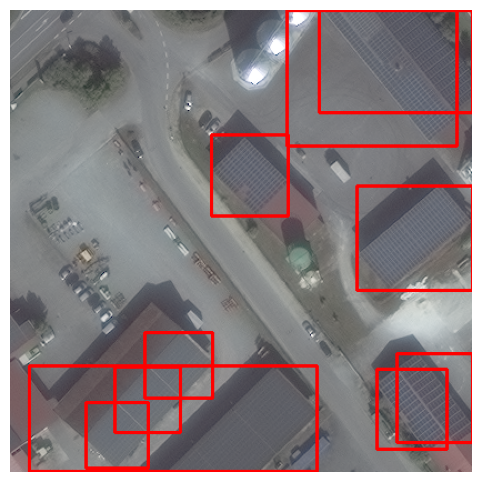

In [5]:
# Visualize one image
sample_image = "solarpanels_native_2__x0_0_y0_11248_dxdy_416.tif"
plot_bounding_boxes(os.path.join(images_dir, sample_image),
                    os.path.join(labels_dir, sample_image.replace(".tif", ".txt")))

Every pixel in the image corresponds to a real world location.
In the Readme_label file it was mentioned that our dataset uses the EPSG:32633 coordinate system, which is UTM Zone 33N. Instead of latitude/longitude, UTM uses meters as units.

- The pixel coordinates may be translated to geocoordinates using the following geotransform for each tile:
- A geotransform is a set of values that tells us how pixel coordinates in an image map to real-world geocoordinates.


`[origin_x ,pixel_width, rotation,origin_y, Rotation, Pixel Height]`

Tile 1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31)
 
Tile 2: (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31)

Tile 3: (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)

Our data contain images generated from 3 different tiles which can be found using the name of the image.

We can convert pixel values into geocoordinates using the following transformation:

- x_geo​ =x_origin​ +(x_pixel​ ×pixel_width)
- y_geo​ =y_origin​ +(y_pixel​ ×pixel_height)
- width in meters=(width in pixels)×pixel width
- height in meters=(height in pixels)×pixel height


In [6]:
tile_1 = df[df['image_name'].str.contains('solarpanels_native_1')]
tile_2 = df[df['image_name'].str.contains('solarpanels_native_2')]
tile_3 = df[df['image_name'].str.contains('solarpanels_native_3')]

def pixel_to_geo(x_pixel, y_pixel, width_pixel, height_pixel, geotransform):

    # Convert pixel coordinates to real-world geocoordinates
    x_geo = geotransform[0] + (x_pixel * geotransform[1])
    y_geo = geotransform[3] + (y_pixel * geotransform[5])  # y transformation uses the negative pixel height

    # Convert width and height to meters
    width_meters = width_pixel * geotransform[1]
    height_meters = height_pixel * abs(geotransform[5])  # Use abs() to ensure positive height

    return x_geo, y_geo, width_meters, height_meters

geotransform_tile1 = (307670.04, 0.31, 0.0, 5434427.1, 0.0, -0.31)
geotransform_tile2 = (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31)
geotransform_tile3 = (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)
# Example YOLO label values
x_pixel1,y_pixel1,width_pixel1,height_pixel1 = tile_1['x_pixel'],tile_1['y_pixel'],tile_1['width_pixel'],tile_1['height_pixel']
x_pixel2,y_pixel2,width_pixel2,height_pixel2 = tile_2['x_pixel'],tile_2['y_pixel'],tile_2['width_pixel'],tile_2['height_pixel']
x_pixel3,y_pixel3,width_pixel3,height_pixel3 = tile_3['x_pixel'],tile_3['y_pixel'],tile_3['width_pixel'],tile_3['height_pixel']

# Convert
x_geo1, y_geo1, width_meters1, height_meters1 = pixel_to_geo(x_pixel1, y_pixel1, width_pixel1, height_pixel1, geotransform_tile1)
x_geo2, y_geo2, width_meters2, height_meters2 = pixel_to_geo(x_pixel2, y_pixel2, width_pixel2, height_pixel2, geotransform_tile2)
x_geo3, y_geo3, width_meters3, height_meters3 = pixel_to_geo(x_pixel3, y_pixel3, width_pixel3, height_pixel3, geotransform_tile3)

x_geo = pd.concat([x_geo1,x_geo2,x_geo3])
y_geo = pd.concat([y_geo1,y_geo2,y_geo3])
width_meters = pd.concat([width_meters1,width_meters2,width_meters3])
height_meters = pd.concat([height_meters1,height_meters2,height_meters3])

In [7]:
df['x_geo'] = x_geo
df['y_geo'] = y_geo
df['width_meters'] = width_meters
df['height_meters'] = height_meters

In [8]:
df

image_name  category  x_center  \
0        solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif       0.0  0.872596   
1        solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif       0.0  0.620192   
2        solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif       0.0  0.723558   
3        solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif       0.0  0.875000   
4        solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif       0.0  0.915865   
...                                                  ...       ...       ...   
29620  solarpanels_native_3__x0_9990_y0_9864_dxdy_416...       0.0  0.492788   
29621  solarpanels_native_3__x0_9990_y0_9864_dxdy_416...       0.0  0.354567   
29622  solarpanels_native_3__x0_9990_y0_9864_dxdy_416...       0.0  0.435096   
29623  solarpanels_native_3__x0_9990_y0_9864_dxdy_416...       0.0  0.646635   
29624  solarpanels_native_3__x0_9990_y0_9864_dxdy_416...       0.0  0.776442   

       y_center     width    height  x_pixel  y_pixel  width_pixel  \
0      0.700721  0.057692  0.055288      363      291           24   
1      0.682692  0.043269  0.038462      258      284           18   
2      0.754808  0.052885  0.052885      301      314           22   
3      0.935096  0.028846  0.028846      364      389           12   
4      0.959135  0.043269  0.033654      381      399           18   
...         ...       ...       ...      ...      ...          ...   
29620  0.853365  0.230769  0.293269      205      355           96   
29621  0.878606  0.151442  0.204327      147      365           63   
29622  0.878606  0.225962  0.242788      181      365           94   
29623  0.774038  0.216346  0.307692      269      322           90   
29624  0.612981  0.336538  0.427885      323      255          140   

       height_pixel      x_geo       y_geo  width_meters  height_meters  
0                23  307782.57  5434336.89          7.44           7.13  
1                16  307750.02  5434339.06          5.58           4.96  
2                22  307763.35  5434329.76          6.82           6.82  
3                12  307782.88  5434306.51          3.72           3.72  
4                14  307788.15  5434303.41          5.58           4.34  
...             ...        ...         ...           ...            ...  
29620           122  312812.63  5363210.49         29.76          37.82  
29621            85  312794.65  5363207.39         19.53          26.35  
29622           101  312805.19  5363207.39         29.14          31.31  
29623           128  312832.47  5363220.72         27.90          39.68  
29624           178  312849.21  5363241.49         43.40          55.18  

[29625 rows x 14 columns]

In [9]:
os.makedirs("data/processed_data", exist_ok=True)
df.to_csv("data/processed_data/converted_labels.csv", index=False)

## Data Exploration and Understanding

In [10]:
df = pd.read_csv("data/processed_data/converted_labels.csv")

### Dataset statistics 
#### 1. How many instances of solar panels are present in the dataset?


In [11]:
## Each row in dataset corresponds to 1 solar panel
print("Number of solar panels in dataset: ", len(df))

Number of solar panels in dataset:  29625


#### 2. Compute and show the value counts of labels per image

In [12]:
labels_per_image = df['image_name'].value_counts()

label_distribution = labels_per_image.value_counts()
pd.DataFrame({"No_of_images":label_distribution.index,"labels":label_distribution.values})

No_of_images  labels
0              3     221
1              4     218
2              5     217
3              6     189
4              8     184
..           ...     ...
69            55       1
70            64       1
71            22       1
72            61       1
73            78       1

[74 rows x 2 columns]

### Calculate the statistics of the area of solar panels in meters

#### 1. What method was used to compute the area (in meters) for a single instance?

Ans. Since we have already calculated the geo-coordinates we can multiply the widht and height of the bounding box to get an estimate of area in meter

In [13]:
### TO calculate the area we will need to use the geo-coordinates
print("total Area : ",sum(df['width_meters']*df['height_meters']))

total Area :  5673715.650499898


#### 2. What is the mean area and standard deviation?


In [14]:
Area = df['width_meters']*df['height_meters']
print('mean area: ',np.mean(Area))
print('standard deviation of area: ',np.std(Area))

mean area:  191.5178278649789
standard deviation of area:  630.7003355500086


#### 3. Plot the histogram of areas. What do you observe?

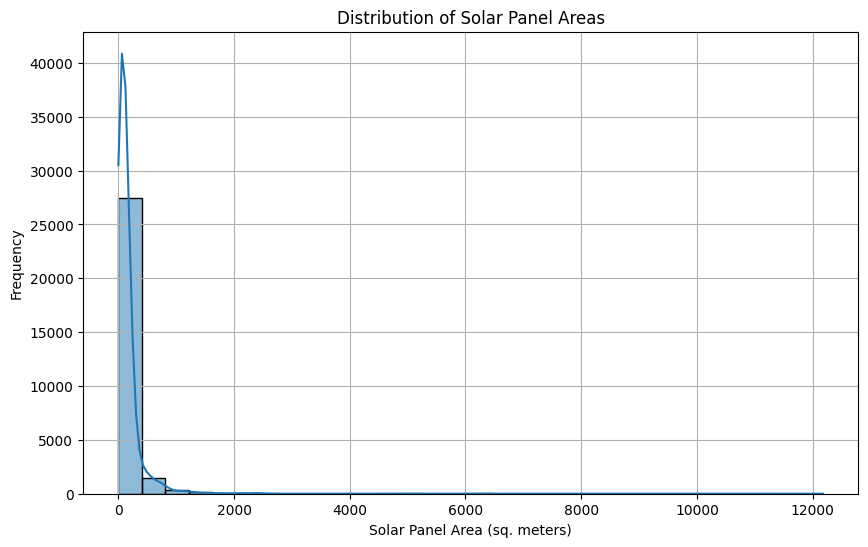

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(Area, bins=30, kde=True)

plt.xlabel("Solar Panel Area (sq. meters)")
plt.ylabel("Frequency")
plt.title("Distribution of Solar Panel Areas")
plt.grid(True)
plt.show()

In [16]:
# Compute histogram bin edges and counts
counts, bin_edges = np.histogram(Area, bins=30)

# Compute bin size (width of each bin)
bin_size = bin_edges[1] - bin_edges[0]

print(f"Bin size: {bin_size} square meters")

27432/len(df)

Bin size: 405.87834999999995 square meters


0.9259746835443038

We can say that majrity of th e solar panels (92.6%) have area less than 407 m^2

## Implementing the Fundamental Functions

#### 1. Write a function to compute IoU (Intersection over Union)
 between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library 


 From the provided blog
- Intersection over Union is an evaluation metric used to measure the accuracy of an object detector.
- in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:
- https://supervision.roboflow.com/detection/utils/#supervision.detection.utils.box_iou_batch

    -  The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
    - The predicted bounding boxes from our model.
    
- IoU=  Area of Union/Area of Intersection
​
Reference : 
- https://shapely.readthedocs.io/en/2.0.6/manual.html#object.union
- https://shapely.readthedocs.io/en/2.0.6/manual.html#object.area

In [17]:
## After converting the bounding box into shapely object we can use the union 
## intersection and area methodmethod to calculate the area of the union of the two bounding boxes

def yolo_to_bbox(yolo_box):
        x_c, y_c, w, h = yolo_box

        x_min = x_c - w / 2
        y_min = y_c - h / 2
        x_max = x_c + w / 2
        y_max = y_c + h / 2
        return x_min, y_min, x_max, y_max
    
def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = yolo_to_bbox(box1)
    x2_min, y2_min, x2_max, y2_max = yolo_to_bbox(box2)

    bbox1 = box(x1_min, y1_min, x1_max, y1_max)
    bbox2 = box(x2_min, y2_min, x2_max, y2_max)

    intersection_area = bbox1.intersection(bbox2).area
    union_area = bbox1.union(bbox2).area

    iou = intersection_area / union_area 
    return iou


box1 = (363,291,24,23) 
box2 = (367,289,20,20) 

iou_value = compute_iou(box1, box2)
print(f"IoU from custom function: {iou_value}")

## Take a batch of bounding box as input
bbox1 = np.array([yolo_to_bbox(box1)])
bbox2 = np.array([yolo_to_bbox(box2)])
print(f"IoU from Supervision library : {box_iou_batch(bbox1, bbox2)}")

IoU from custom function: 0.5840266222961731
IoU from Supervision library : [[    0.58403]]


#### 2. Write a function to compute Average Precision (AP) 

- True positive and True negative are calculated based on the IoU threshold.
- AP is the area under the precision-recall curve.
- We require precision, recall, IoU and AUC to calculate AP. 

Reference to solve this:
- https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/

In [40]:
### Getting all the functions together

# Function to compute IoU using Shapely
def compute_iou(gt_box, pred_box):
    iou = box_iou_batch(np.array(gt_box), np.array(pred_box))
    ans = []
    for i in iou:
        ans.append(max(i))
    return np.array(ans)

def get_precision_and_recall(iou, conf_scores, iou_threshold=0.5):
    sorted_idx = np.argsort(conf_scores)[::-1]  # Sort by confidence scores in descending order
    tp = (iou >= iou_threshold).astype(int)
    fp = (iou < iou_threshold).astype(int)
    tp = tp[sorted_idx]
    fp = fp[sorted_idx]

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / len(cum_tp)

    return recall, precision

def VOC_11(recall, precision):
    recal_11 = np.linspace(0, 1, 11)
    precision_11 = np.zeros(11)
    for i, r in enumerate(recal_11):
        
        precision_11[i] = max(precision[recall >= r] if len(precision[recall >=r]) > 0 else [0])
    
    average_precision = np.mean(precision_11)
    return average_precision

def COCO_101(recall, precision):
    recal_11 = np.linspace(0, 1, 101)
    precision_11 = np.zeros(101)
    for i, r in enumerate(recal_11):
        
        precision_11[i] = max(precision[recall >= r] if len(precision[recall >=r]) > 0 else [0])
    
    average_precision = np.mean(precision_11)
    return average_precision

def AUC(recall, precision):
    sorted_indices = np.argsort(recall)
    recall_sorted = np.array(recall)[sorted_indices]
    precision_sorted = np.array(precision)[sorted_indices]
    return auc(recall_sorted, precision_sorted)


In [43]:
num_images = 10
image_size = 100
box_size = 20
np.random.seed(0)

gt_boxes = []
conf_scores = np.random.rand(num_images) 
for _ in range(num_images):
    x_gt, y_gt = np.random.randint(0, image_size - box_size, size=2)
    gt_boxes.append([x_gt, y_gt, x_gt + box_size, y_gt + box_size])

noise_level = 5
pred_boxes = []
for gt_box in gt_boxes:
    x_noise, y_noise = np.random.randint(-noise_level, noise_level + 1, size=2)
    x_pred, y_pred = max(0, gt_box[0] + x_noise), max(0, gt_box[1] + y_noise)
    pred_boxes.append([x_pred, y_pred, x_pred + box_size, y_pred + box_size])


Average Precision (VOC 11 points): 0.5181818181818182
Average Precision (COCO 101 points): 0.5465346534653468
 Average Precision (AUC): 0.20124999999999998


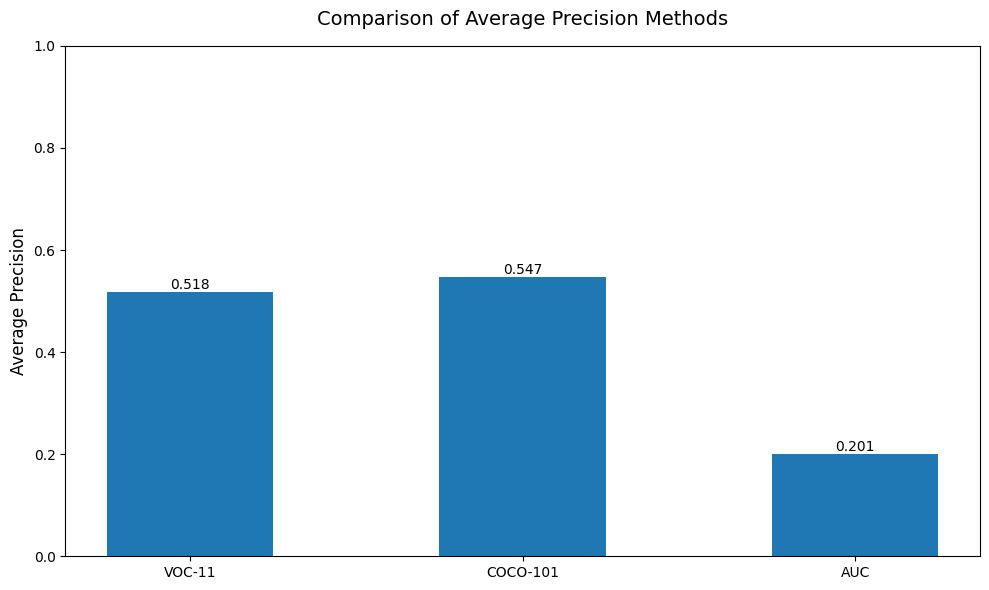

In [44]:
iou = compute_iou(gt_boxes, pred_boxes)
precision, recall = get_precision_and_recall(iou, conf_scores, iou_threshold = 0.5)
print("Average Precision (VOC 11 points):", VOC_11(recall, precision))
print("Average Precision (COCO 101 points):", COCO_101(recall, precision))
print(" Average Precision (AUC):", AUC(recall, precision))


methods = ['VOC-11', 'COCO-101', 'AUC']
ap_values = [VOC_11(recall, precision), COCO_101(recall, precision), AUC(recall, precision)]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, ap_values, width=0.5)

plt.title('Comparison of Average Precision Methods', fontsize=14, pad=15)
plt.ylabel('Average Precision', fontsize=12)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')
plt.tight_layout()
plt.show()


## Model building and evaluation 

#### 1. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

Reference:

- https://docs.ultralytics.com/models/yolo11/#how-do-i-train-a-yolo11-model-for-object-detection
- https://docs.ultralytics.com/modes/

In [22]:
df = pd.read_csv("data/processed_data/converted_labels.csv")
df['label_path'] = df['image_name'].str.replace(".tif", ".txt")
df = df[['image_name', 'label_path', 'category']]
df = df.groupby('image_name').first().reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df['category'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42,stratify=train_df['category'])

print(train_df['category'].value_counts())
print(val_df['category'].value_counts())
print(test_df['category'].value_counts())

os.makedirs("data/yolo_data", exist_ok=True)
os.makedirs("datasets/images/train", exist_ok=True)
os.makedirs("datasets/images/val", exist_ok=True)
os.makedirs("datasets/images/test", exist_ok=True)
os.makedirs("datasets/labels/train", exist_ok=True)
os.makedirs("datasets/labels/val", exist_ok=True)
os.makedirs("datasets/labels/test", exist_ok=True)

# Create YOLO dataset structure
splits = {
    'train': train_df['image_name'].tolist(),
    'val': val_df['image_name'].tolist(),
    'test': test_df['image_name'].tolist()
}

for split, images in splits.items():
    for img_name in images:
        # Copy image to appropriate directory
        src_img = os.path.join("data/image_chips_native", img_name)
        dst_img = f"datasets/images/{split}/{img_name}"
        shutil.copy2(src_img, dst_img)  # Using shutil.copy2 to preserve metadata
        
        # Create label file
        src_label = os.path.join("data/labels", img_name.replace(".tif", ".txt"))
        dst_label = f"datasets/labels/{split}/{img_name.replace('.tif', '.txt')}"
        shutil.copy2(src_label, dst_label)

category
0.0    1779
2.0      40
1.0      10
Name: count, dtype: int64
category
0.0    198
2.0      5
1.0      1
Name: count, dtype: int64
category
0.0    495
2.0     11
1.0      3
Name: count, dtype: int64


In [23]:
yaml_content = {
        'path': '',
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 3,  # number of classes
        'names': ['0', '1', '2']
    }

with open('data.yaml', 'w') as f:
        yaml.dump(yaml_content, f)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [28]:
# Load a pre-trained YOLOv8 model
model = YOLO('yolo11m.pt')

# Train the model
results = model.train(
    data='data.yaml',
    epochs=200,
    imgsz=416,
    batch=32,
    patience=20,  # Early stopping patience
    device = device,
    save=True,
    plots=True
)

engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=data.yaml, epochs=500, time=None, patience=20, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False,

train: Scanning C:\Users\sarth\Documents\SRIP\datasets\labels\train... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:03<00:00, 576.71it/s]


train: New cache created: C:\Users\sarth\Documents\SRIP\datasets\labels\train.cache


val: Scanning C:\Users\sarth\Documents\SRIP\datasets\labels\val... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<00:00, 336.37it/s]


val: New cache created: C:\Users\sarth\Documents\SRIP\datasets\labels\val.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      7.08G      1.996      2.272      1.488         43        416: 100%|██████████| 58/58 [00:35<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        204       2554       0.56      0.236      0.246      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      7.09G      1.273      0.958      1.021         69        416: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

                   all        204       2554       0.93      0.253      0.277      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      6.89G      1.313     0.9403      1.017         66        416: 100%|██████████| 58/58 [00:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

                   all        204       2554      0.746      0.331      0.301      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      6.95G       1.34     0.8791      1.034        101        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]

                   all        204       2554      0.527      0.297     0.0897     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      6.94G      1.305      0.843      1.023        154        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

                   all        204       2554       0.35      0.297       0.28      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      6.95G       1.26     0.7982      1.012         28        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        204       2554      0.401      0.368      0.303      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      7.01G      1.197     0.7447     0.9921         76        416: 100%|██████████| 58/58 [00:22<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all        204       2554      0.549      0.378      0.327       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      6.95G      1.169     0.6992     0.9897         47        416: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        204       2554       0.23      0.259       0.25      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500         7G      1.171     0.7108     0.9867         62        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

                   all        204       2554      0.808      0.328      0.291      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      7.14G      1.136      0.688      0.978        127        416: 100%|██████████| 58/58 [00:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]

                   all        204       2554      0.469      0.378      0.385      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      6.91G      1.103     0.6535     0.9725        123        416: 100%|██████████| 58/58 [00:22<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

                   all        204       2554      0.865      0.428      0.541      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      6.93G      1.063     0.6261     0.9543         44        416: 100%|██████████| 58/58 [00:23<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

                   all        204       2554      0.624      0.417       0.46      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      6.94G      1.056     0.6248     0.9499         64        416: 100%|██████████| 58/58 [00:22<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        204       2554      0.701       0.39      0.416      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      7.25G      1.043     0.6095     0.9503         57        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]

                   all        204       2554      0.726      0.479      0.493      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      6.88G      1.002     0.5871     0.9423         65        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.812      0.486      0.568      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      6.86G      1.006     0.5843     0.9417         45        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        204       2554      0.709      0.478      0.507      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      6.95G     0.9835     0.5719     0.9295         60        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        204       2554      0.602      0.503      0.501      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      6.98G     0.9794     0.5715      0.938         47        416: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        204       2554      0.426      0.426      0.428      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      6.87G     0.9897     0.5717     0.9295         62        416: 100%|██████████| 58/58 [00:21<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.805      0.566      0.685      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      7.02G     0.9404     0.5437     0.9227         52        416: 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

                   all        204       2554      0.808      0.565      0.665      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      6.89G     0.9314     0.5367     0.9173         40        416: 100%|██████████| 58/58 [00:22<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        204       2554      0.955      0.574      0.713      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      6.96G     0.9183     0.5307     0.9221         88        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        204       2554      0.873      0.598      0.667      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      6.96G     0.9197      0.533      0.912         69        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        204       2554      0.815      0.559      0.623      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      6.91G     0.9131     0.5233     0.9176         82        416: 100%|██████████| 58/58 [00:22<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        204       2554       0.89      0.657      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      6.98G     0.8794     0.5077     0.9112        134        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        204       2554      0.758      0.622      0.644       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500         7G     0.8776     0.5077     0.9027         93        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        204       2554      0.836      0.569      0.567      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500       7.2G     0.8627     0.4948     0.9027         62        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        204       2554      0.929      0.569      0.644      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      6.89G     0.8659     0.4921     0.9038         41        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        204       2554      0.829      0.699      0.762      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      6.93G     0.8562     0.4949     0.9016        100        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        204       2554      0.795      0.705      0.773      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      6.88G     0.8614      0.492     0.8995         87        416: 100%|██████████| 58/58 [00:23<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        204       2554      0.774      0.592      0.634      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      6.91G     0.8551     0.4893      0.902         70        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554       0.83      0.767      0.854      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      6.91G     0.8217     0.4783     0.8915        123        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.931       0.64      0.763      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      7.07G     0.8169     0.4776     0.8882        131        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        204       2554       0.71      0.766      0.791      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      6.84G     0.8086     0.4639     0.8855         88        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        204       2554      0.973       0.73      0.808      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500       6.9G     0.8021     0.4593     0.8859         59        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        204       2554      0.797      0.632       0.64      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      6.95G     0.7823      0.456     0.8855         37        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        204       2554      0.866      0.762      0.819      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      7.01G     0.7751     0.4514      0.883        137        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        204       2554      0.965      0.685      0.754      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500         7G     0.7719     0.4464     0.8826         80        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        204       2554      0.908      0.592      0.756      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      6.99G     0.7718      0.446     0.8791        156        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        204       2554      0.709      0.579      0.628      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      6.94G     0.7609     0.4455     0.8797         73        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554       0.82      0.775      0.817      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      7.11G     0.7504     0.4382     0.8836         60        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.834      0.654      0.704      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      6.98G     0.7436     0.4316     0.8751         57        416: 100%|██████████| 58/58 [00:21<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.784      0.725      0.749      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500       6.9G     0.7509     0.4333     0.8751         65        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.771      0.723      0.691      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      6.88G     0.7372     0.4285     0.8761         38        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        204       2554      0.908      0.683      0.789      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      6.96G     0.7199     0.4225     0.8711         90        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.907       0.78      0.865       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      6.93G     0.7183     0.4224     0.8703         45        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        204       2554      0.917      0.762      0.821      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      7.01G     0.7281     0.4289     0.8717         46        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        204       2554      0.904        0.7      0.841      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      7.18G     0.7078     0.4198     0.8689         53        416: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        204       2554      0.875       0.73      0.824      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500       6.9G     0.7113     0.4173     0.8691         42        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        204       2554      0.814       0.66      0.676      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      6.93G     0.6967     0.4099     0.8643        128        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        204       2554      0.759      0.843      0.845      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      6.88G     0.6878     0.4064     0.8656         60        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        204       2554      0.871      0.822      0.897      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      7.15G      0.687     0.4081     0.8647        112        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        204       2554      0.859      0.889       0.92      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      6.86G     0.7071     0.4149     0.8683         51        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        204       2554      0.904      0.904      0.949      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      7.13G     0.6761     0.4024     0.8593         45        416: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        204       2554      0.929      0.716      0.823      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500         7G     0.6815     0.4055     0.8645         59        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        204       2554      0.976      0.685      0.803      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      6.96G     0.6669     0.3953     0.8602         53        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        204       2554      0.894       0.63      0.731      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      6.94G     0.6604     0.3965     0.8617        183        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        204       2554      0.823      0.751      0.802       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500         7G      0.655     0.3936     0.8609         70        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        204       2554      0.826       0.69      0.728      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      6.95G     0.6677      0.398     0.8616         88        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        204       2554      0.892      0.799      0.846       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      7.14G      0.658     0.3929     0.8566         47        416: 100%|██████████| 58/58 [00:25<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        204       2554      0.893      0.774      0.851      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      7.09G     0.6575     0.3899     0.8566         40        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        204       2554      0.884      0.781       0.83      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      6.96G      0.654     0.3919     0.8548         75        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        204       2554      0.905      0.895      0.938      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      6.93G     0.6429      0.389     0.8537        100        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.945      0.688      0.874      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      6.87G     0.6405     0.3869      0.856         96        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        204       2554      0.941      0.767      0.869      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      6.94G      0.645     0.3852     0.8528         79        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        204       2554      0.864      0.816      0.891       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      6.91G     0.6337     0.3827     0.8537         93        416: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        204       2554      0.919      0.873      0.945      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      6.89G      0.625     0.3785     0.8521         37        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554       0.93      0.881      0.943       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      6.98G     0.6277     0.3796      0.853         66        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        204       2554      0.942      0.905      0.961       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      6.89G     0.6138      0.373     0.8492         82        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554       0.97      0.802      0.879      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      6.93G     0.6065     0.3696     0.8487        137        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.986      0.802      0.937      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      6.87G     0.6045     0.3719     0.8482         64        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        204       2554      0.937      0.852       0.91      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      6.96G     0.5969     0.3659      0.848        128        416: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        204       2554      0.927      0.871      0.959      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      6.92G     0.6015     0.3697      0.848         30        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        204       2554      0.935      0.905      0.925      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      6.99G     0.6043     0.3657     0.8497         62        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        204       2554      0.956      0.945      0.984      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      7.13G     0.5923     0.3591     0.8453        111        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        204       2554        0.9      0.883      0.945      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      7.09G      0.584     0.3617     0.8451         62        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        204       2554      0.962      0.951      0.987      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      6.86G     0.5755     0.3544     0.8425         98        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

                   all        204       2554      0.986      0.903      0.979      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      6.93G     0.5836     0.3583     0.8443         83        416: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        204       2554      0.961      0.882      0.906      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      7.21G     0.5884     0.3605     0.8465         69        416: 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

                   all        204       2554      0.871      0.946      0.954      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      6.91G     0.5803     0.3533     0.8443         71        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.988      0.913      0.984      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      7.17G     0.5798     0.3565      0.843         65        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        204       2554      0.951      0.921      0.975      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      6.85G     0.5803     0.3575     0.8419        111        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        204       2554      0.862      0.886      0.951      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500         7G     0.5707     0.3517     0.8379        127        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        204       2554      0.897      0.984      0.948      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      6.93G     0.5638     0.3508     0.8406         88        416: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        204       2554      0.905       0.74      0.841      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      6.87G     0.5766      0.356     0.8431         58        416: 100%|██████████| 58/58 [00:23<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        204       2554      0.894      0.921      0.963      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      7.03G     0.5575     0.3494     0.8404         56        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        204       2554      0.948      0.938      0.973      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      6.88G      0.551     0.3465     0.8446         55        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        204       2554      0.883      0.903      0.952      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      7.04G     0.5596     0.3468     0.8388         34        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        204       2554      0.982      0.988      0.991      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500       7.1G      0.551     0.3433     0.8394         87        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        204       2554      0.953      0.841      0.937      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      6.85G     0.5652     0.3493     0.8404         65        416: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        204       2554      0.847      0.915      0.909      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      7.28G     0.5581     0.3467      0.839         84        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        204       2554      0.976      0.949      0.988      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      6.89G     0.5417     0.3383     0.8363        105        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        204       2554      0.892      0.951      0.965      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      7.17G     0.5379     0.3388     0.8382         32        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        204       2554      0.917      0.804      0.925      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      7.12G     0.5416     0.3397     0.8386        134        416: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        204       2554      0.989      0.967      0.991      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      6.96G     0.5391     0.3378     0.8373         90        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        204       2554      0.959      0.948      0.987      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      7.18G     0.5388     0.3357     0.8356        104        416: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        204       2554      0.988       0.97      0.991       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      7.27G     0.5397     0.3387     0.8364        107        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        204       2554      0.928      0.951      0.971      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      6.96G     0.5371     0.3379     0.8361         40        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.979      0.986      0.991      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      6.88G     0.5325     0.3351     0.8339         49        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        204       2554      0.946      0.913      0.971      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      6.93G     0.5247     0.3329      0.837         40        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.931      0.952      0.972      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      6.96G     0.5167     0.3287     0.8306         53        416: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        204       2554      0.986      0.969       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      6.89G     0.5277     0.3347      0.838         44        416: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        204       2554       0.99      0.935      0.988      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      6.97G     0.5233      0.331     0.8337         40        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        204       2554      0.963      0.909      0.985      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      6.99G      0.526     0.3302     0.8335         51        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        204       2554      0.992      0.978      0.991      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      6.94G     0.5214     0.3328     0.8353        131        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        204       2554      0.987      0.952      0.988      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      6.96G     0.4999     0.3189     0.8293         66        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        204       2554      0.987      0.874      0.958      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      6.89G     0.5213     0.3275     0.8315         62        416: 100%|██████████| 58/58 [00:21<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        204       2554      0.988      0.957      0.991      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      6.93G     0.5179     0.3274     0.8323        114        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.987      0.961      0.991      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      6.93G     0.5088     0.3224      0.831        120        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        204       2554      0.929      0.879      0.966      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      6.82G      0.518     0.3266      0.833         42        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        204       2554      0.924      0.989      0.979      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      6.93G     0.5139     0.3251     0.8311         71        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        204       2554      0.966      0.948      0.973      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      6.96G     0.5157     0.3266     0.8316         58        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.944      0.959      0.988       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      6.93G     0.5046      0.324     0.8288         65        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        204       2554      0.949      0.939      0.966      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      6.96G     0.5005      0.318     0.8295        101        416: 100%|██████████| 58/58 [00:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

                   all        204       2554      0.993      0.969      0.992      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      6.89G     0.5035     0.3195     0.8315         48        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        204       2554      0.986      0.946      0.977      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      6.85G     0.5012     0.3186     0.8285         47        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        204       2554      0.939       0.95      0.961      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      6.88G     0.4942     0.3164     0.8283        131        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.987       0.98      0.992      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      6.87G      0.499     0.3198     0.8318         75        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        204       2554      0.962      0.948      0.974      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      6.87G     0.4963     0.3165     0.8307        129        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        204       2554      0.934      0.963       0.98      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      6.91G     0.4903     0.3145     0.8286         69        416: 100%|██████████| 58/58 [00:23<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        204       2554      0.988      0.978      0.991      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      6.95G     0.5024     0.3183     0.8292        105        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        204       2554      0.965      0.946      0.967      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      6.91G     0.4873     0.3116     0.8262         45        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        204       2554      0.985      0.985      0.992       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      6.94G     0.4845     0.3131     0.8274        105        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        204       2554      0.953      0.928      0.978      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      7.16G     0.4882     0.3125     0.8262        108        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]

                   all        204       2554      0.992      0.904      0.966      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      6.93G     0.4901      0.314     0.8298         72        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

                   all        204       2554      0.929      0.949      0.981      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      6.88G     0.4881     0.3112     0.8259         99        416: 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        204       2554      0.967       0.95      0.985      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      6.95G     0.4832     0.3087     0.8266        102        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        204       2554      0.974      0.951      0.988      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      6.95G     0.4842     0.3127     0.8258         53        416: 100%|██████████| 58/58 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        204       2554      0.955      0.953      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      7.15G     0.4783     0.3089     0.8271        150        416: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

                   all        204       2554       0.98      0.985      0.991      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      6.87G     0.4762       0.31     0.8284         60        416: 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        204       2554      0.984      0.984      0.991      0.838
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 110, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



130 epochs completed in 0.972 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 40.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.78  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


                   all        204       2554      0.925      0.989      0.979      0.873
                     0        204       2535      0.982      0.966      0.987      0.901
                     1          9         10      0.901          1      0.968      0.796
                     2          9          9      0.892          1      0.984      0.922
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train


In [29]:
model.export(format="onnx")

Ultralytics 8.3.78  Python-3.10.16 torch-2.6.0+cu126 CPU (Intel Core(TM) i7-14700HX)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 7, 3549) (38.6 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  2.8s, saved as 'runs\detect\train\weights\best.onnx' (76.6 MB)

Export complete (3.5s)
Results saved to C:\Users\sarth\Documents\SRIP\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.onnx imgsz=416  
Validate:        yolo val task=detect model=runs\detect\train\weights\best.onnx imgsz=416 data=data.yaml  
Visualize:       https://netron.app


'runs\\detect\\train\\weights\\best.onnx'

In [47]:
model = YOLO('runs/detect/train/weights/best.pt')
metrics = model.val()

Ultralytics 8.3.78  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning C:\Users\sarth\Documents\SRIP\datasets\labels\val.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


                   all        204       2554      0.925      0.989      0.979      0.876
                     0        204       2535      0.981      0.966      0.987      0.903
                     1          9         10      0.901          1      0.968      0.803
                     2          9          9      0.892          1      0.984      0.922
Speed: 0.4ms preprocess, 7.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val


In [30]:
results = pd.read_csv('runs/detect/train/results.csv')
results.head()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   40.2811         1.99636         2.27204         1.48792   
1      2   67.7755         1.27336         0.95800         1.02116   
2      3   97.3285         1.31302         0.94029         1.01685   
3      4  126.0450         1.34048         0.87914         1.03395   
4      5  153.6990         1.30485         0.84297         1.02283   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.56025            0.23636           0.24646   
1               0.92961            0.25339           0.27665   
2               0.74558            0.33105           0.30149   
3               0.52710            0.29737           0.08967   
4               0.34952            0.29706           0.27970   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.14761       1.33274       1.01494       1.04637  0.003276   
1              0.16810       1.24738       0.90811       0.98140  0.006596   
2              0.16649       1.39062       3.28978       1.05475  0.009903   
3              0.06269       1.64326      12.34880       1.25464  0.009941   
4              0.16767       1.37267       2.06873       1.08067  0.009921   

     lr/pg1    lr/pg2  
0  0.003276  0.003276  
1  0.006596  0.006596  
2  0.009903  0.009903  
3  0.009941  0.009941  
4  0.009921  0.009921

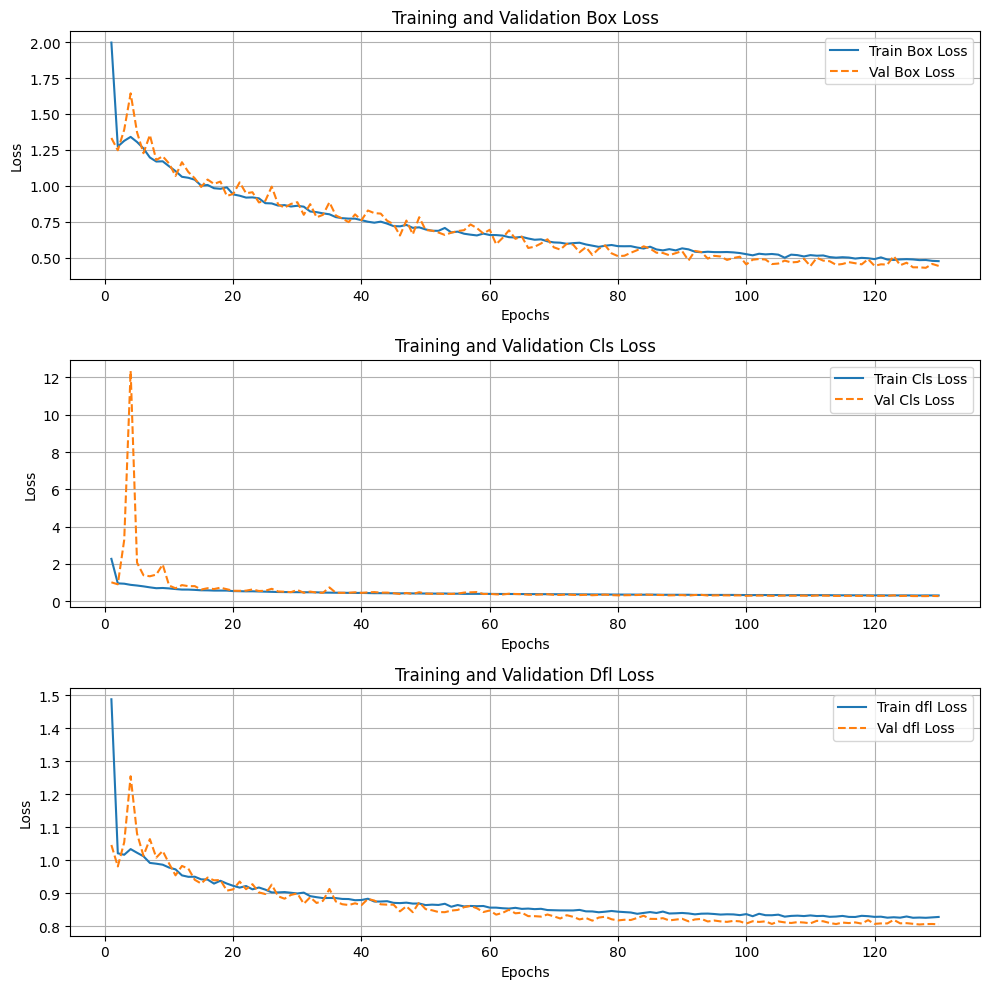

In [31]:
%matplotlib inline

fig, axs = plt.subplots(3, 1, figsize=(10,10))

axs[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', linestyle='-')
axs[0].plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Box Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(results['epoch'], results['train/cls_loss'], label='Train Cls Loss', linestyle='-')
axs[1].plot(results['epoch'], results['val/cls_loss'], label='Val Cls Loss', linestyle='--')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Cls Loss')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(results['epoch'], results['train/dfl_loss'], label='Train dfl Loss', linestyle='-')
axs[2].plot(results['epoch'], results['val/dfl_loss'], label='Val dfl Loss', linestyle='--')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].set_title('Training and Validation Dfl Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

It can be seen that the validation Loss and the training Loss converge

#### 2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 

Reference:
- https://docs.ultralytics.com/modes/predict/#key-features-of-predict-mode

In [25]:
model = YOLO('runs/detect/train/weights/best.pt')

In [26]:
test_image_path = ("datasets/images/test/" + test_df['image_name']).to_list()

df_pred = pd.DataFrame(columns=["image_name", "category", "x1_pred", "y1_pred", "x2_pred", "y2_pred", "confidence"])

for image in test_image_path:
    results = model(image)[0]  
    boxes = results.boxes  

    for box in boxes:
        x1, y1, x2, y2 = list(box.xyxy[0].tolist()) 
        conf = box.conf[0].item()  
        cls = int(box.cls[0])  

        row = pd.DataFrame([{
            "image_name": image.split("/")[-1], 
            "category": cls, 
            "x1_pred": x1, 
            "y1_pred": y1, 
            "x2_pred": x2, 
            "y2_pred": y2, 
            "confidence": conf
        }])

        df_pred = pd.concat([df_pred, row], ignore_index=True)  # Ensure indexing is reset


image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_11167_y0_7069_dxdy_416.tif: 416x416 1 0, 8.4ms
Speed: 1.1ms preprocess, 8.4ms inference, 86.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_7748_y0_9311_dxdy_416.tif: 416x416 5 0s, 7.8ms
Speed: 0.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_2__x0_0_y0_11689_dxdy_416.tif: 416x416 29 0s, 8.8ms
Speed: 0.7ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_5899_y0_13919_dxdy_416.tif: 416x416 3 0s, 7.1ms
Speed: 0.5ms preprocess, 7.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_nativ

Speed: 0.8ms preprocess, 7.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_9363_y0_14944_dxdy_416.tif: 416x416 16 0s, 7.2ms
Speed: 0.5ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_2__x0_9339_y0_3947_dxdy_416.tif: 416x416 9 0s, 7.0ms
Speed: 0.5ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_11802_y0_9198_dxdy_416.tif: 416x416 50 0s, 7.6ms
Speed: 0.6ms preprocess, 7.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 c:\Users\sarth\Documents\SRIP\datasets\images\test\solarpanels_native_3__x0_9282_y0_13052_dxdy_416.tif: 416x416 4 0s, 1 2, 6.9ms
Speed: 0.6ms preprocess, 6.9ms inference, 1.0ms postprocess per image 

In [27]:
df = pd.read_csv("data/processed_data/converted_labels.csv")
df_actual = df[df['image_name'].isin(test_df['image_name'])]
df_actual = df_actual[['image_name', 'category', 'x_pixel', 'y_pixel', 'width_pixel', 'height_pixel']]
# Convert xywh to xyxy format
x1 = df_actual['x_pixel'] - df_actual['width_pixel'] / 2
y1 = df_actual['y_pixel'] - df_actual['height_pixel'] / 2
x2 = x1 + df_actual['width_pixel']
y2 = y1 + df_actual['height_pixel']
df_actual['x1'] = x1
df_actual['y1'] = y1
df_actual['x2'] = x2
df_actual['y2'] = y2

df_actual = df_actual[['image_name', 'category', 'x1', 'y1', 'x2', 'y2']]

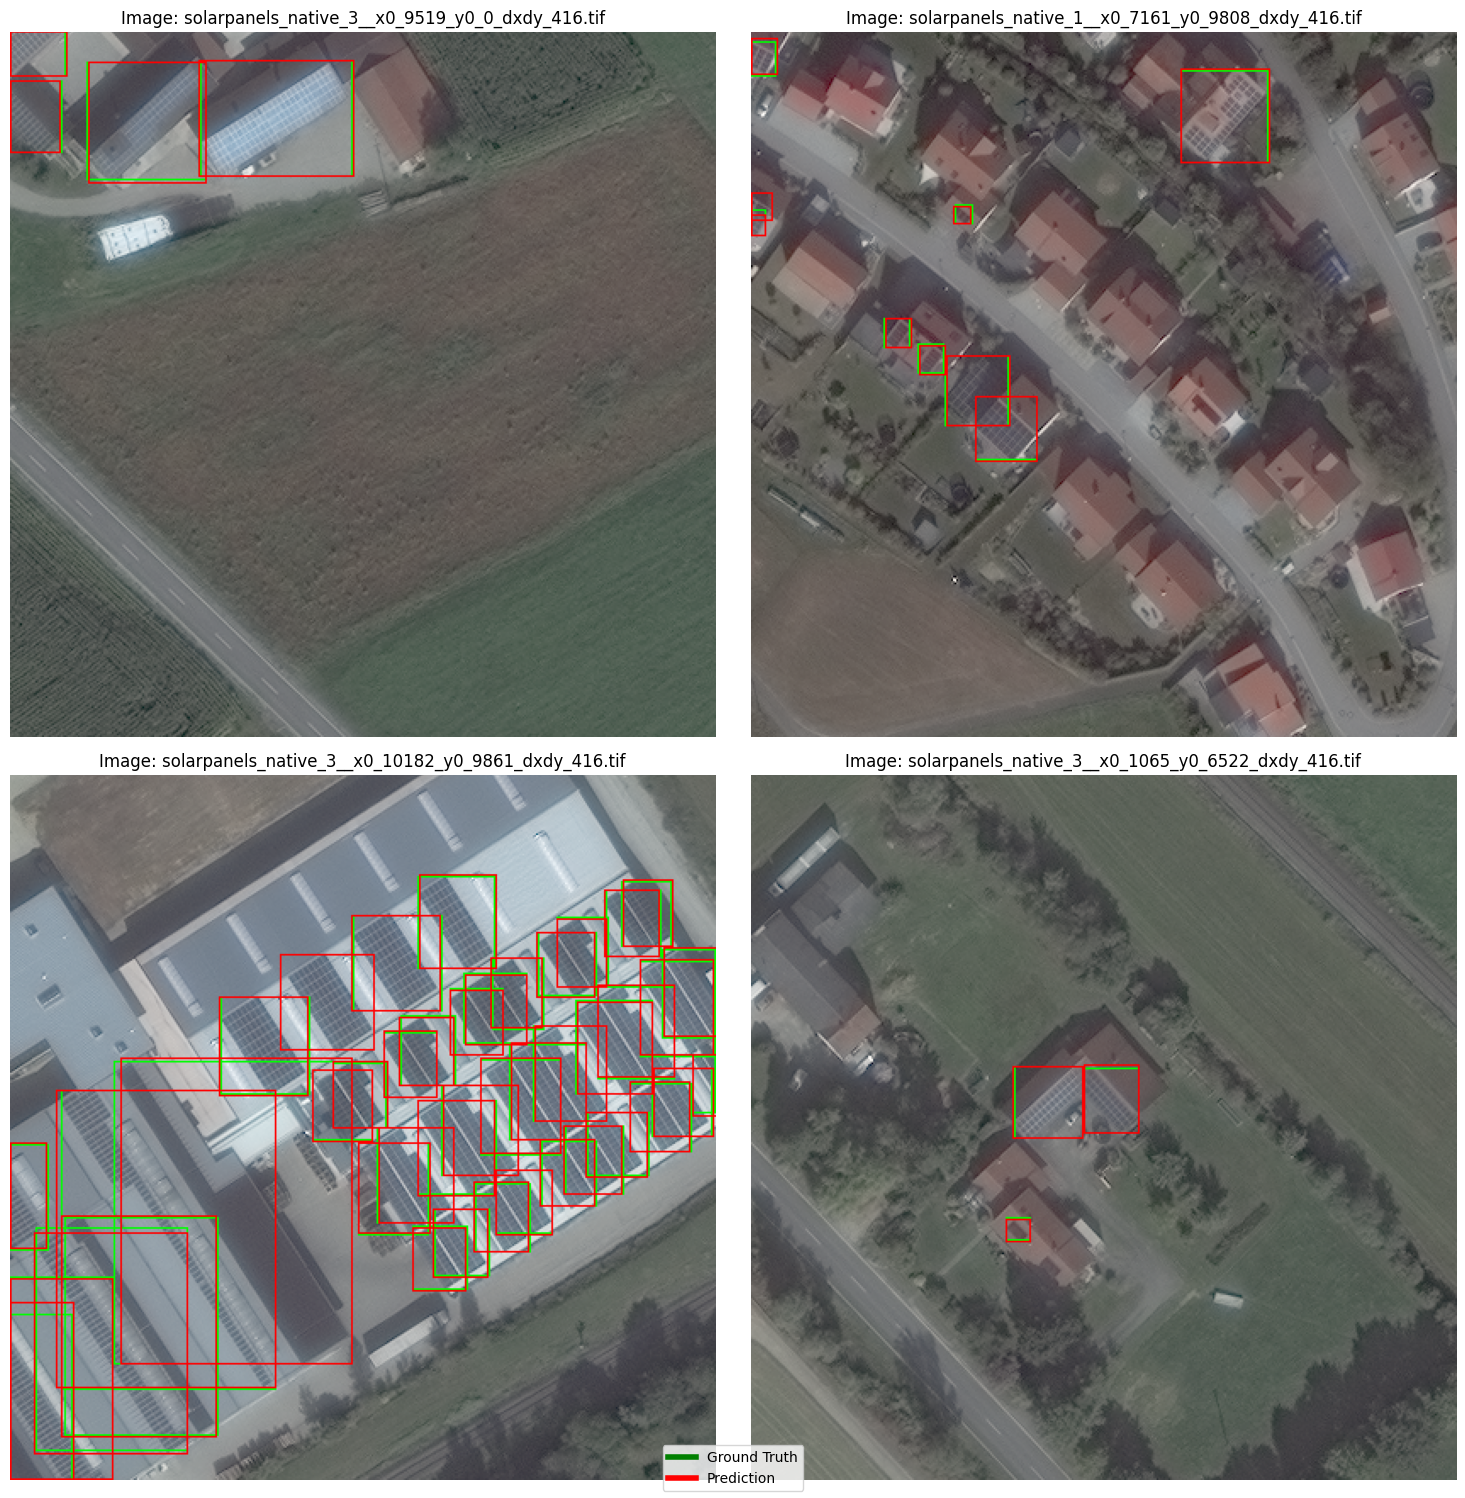

In [28]:
image_names = df_actual["image_name"].unique()
random_images = random.sample(list(image_names), 4)

GT_COLOR = (0, 255, 0)   
PRED_COLOR = (255, 0, 0) 

fig, axes = plt.subplots(2, 2, figsize=(15, 15)) 

for i, img_name in enumerate(random_images):
    # Load image
    img = cv2.imread(f"data/image_chips_native/{img_name}")  
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    gt_boxes = df_actual[df_actual["image_name"] == img_name]
    pred_boxes = df_pred[df_pred["image_name"] == img_name]
    
    for _, row in gt_boxes.iterrows():
        x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]]) 
        cv2.rectangle(img, (x1, y1), (x2, y2), GT_COLOR, 1) 

    for _, row in pred_boxes.iterrows():
        x1, y1, x2, y2 = map(int, [row["x1_pred"], row["y1_pred"], row["x2_pred"], row["y2_pred"]]) 
        cv2.rectangle(img, (x1, y1), (x2, y2), PRED_COLOR, 1)  

    row, col = divmod(i, 2)
    axes[row, col].imshow(img)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Image: {img_name}")

legend_patches = [
    plt.Line2D([0], [0], color="green", lw=4, label="Ground Truth"),
    plt.Line2D([0], [0], color="red", lw=4, label="Prediction")
]
fig.legend(handles=legend_patches, loc="lower center")

plt.tight_layout()
plt.show()


#### 3(a) Compute mAP50 with supervision and compare with your implementation. What do you observe 

Reference:

https://supervision.roboflow.com/metrics/detection/#meanaverageprecision

In [29]:
df_actual

image_name  category     x1  \
8        solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif       0.0  351.0   
9        solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif       0.0  249.0   
10       solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif       0.0  290.0   
11       solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif       0.0  358.0   
12       solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif       0.0  372.0   
...                                                  ...       ...    ...   
29527  solarpanels_native_3__x0_9847_y0_14845_dxdy_41...       0.0  189.0   
29528  solarpanels_native_3__x0_9847_y0_14845_dxdy_41...       0.0   35.0   
29529  solarpanels_native_3__x0_9847_y0_14845_dxdy_41...       0.0   -0.5   
29579  solarpanels_native_3__x0_9930_y0_11187_dxdy_41...       0.0  144.5   
29580  solarpanels_native_3__x0_9930_y0_11187_dxdy_41...       0.0  168.0   

          y1     x2     y2  
8      161.5  375.0  184.5  
9      158.0  267.0  174.0  
10     185.0  312.0  207.0  
11     265.0  370.0  277.0  
12     274.0  390.0  288.0  
...      ...    ...    ...  
29527  227.5  219.0  260.5  
29528  186.5   51.0  195.5  
29529  126.5    4.5  133.5  
29579  158.5  157.5  179.5  
29580  241.5  192.0  264.5  

[6013 rows x 6 columns]

In [30]:
df_pred

image_name category     x1_pred  \
0     solarpanels_native_3__x0_11167_y0_7069_dxdy_41...        0  227.926926   
1     solarpanels_native_3__x0_7748_y0_9311_dxdy_416...        0  124.212158   
2     solarpanels_native_3__x0_7748_y0_9311_dxdy_416...        0  215.076782   
3     solarpanels_native_3__x0_7748_y0_9311_dxdy_416...        0  306.987671   
4     solarpanels_native_3__x0_7748_y0_9311_dxdy_416...        0  379.100342   
...                                                 ...      ...         ...   
6128  solarpanels_native_3__x0_9930_y0_11187_dxdy_41...        0  144.980850   
6129    solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif        0  282.774902   
6130    solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif        0  217.385437   
6131    solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif        0  157.493881   
6132    solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif        0  157.308746   

         y1_pred     x2_pred     y2_pred  confidence  
0     233.169525  293.269836  258.240021    0.887947  
1     225.982422  180.257996  278.246704    0.925895  
2     215.161102  246.826233  253.564148    0.923654  
3     299.666382  335.169800  324.617920    0.919160  
4     259.770447  400.684631  292.035950    0.886069  
...          ...         ...         ...         ...  
6128  158.618851  158.686630  179.719040    0.864246  
6129   18.046600  372.899658   85.554169    0.939570  
6130   18.375488  286.730957   89.473785    0.928061  
6131   28.466232  200.271286   71.561272    0.915824  
6132    0.000000  209.595062   26.923002    0.832816  

[6133 rows x 7 columns]

In [31]:
## getting our predictions and actuals in the format required for the evaluation by supervision library
predictions = []
targets = []

for image_name in df_actual["image_name"].unique():
    actual_boxes = df_actual[df_actual["image_name"] == image_name]
    gt_array = actual_boxes[["x1", "y1", "x2", "y2", "category"]].to_numpy()
    targets.append(gt_array)

    pred_boxes = df_pred[df_pred["image_name"] == image_name]
    if not pred_boxes.empty:
        pred_array = pred_boxes[["x1_pred", "y1_pred", "x2_pred", "y2_pred", "category", "confidence"]].to_numpy()
    else:
        pred_array = np.empty((0, 6))  

    predictions.append(pred_array)


In [32]:
mean_average_precison = sv.MeanAveragePrecision.from_tensors(
    predictions=predictions,
    targets=targets,
)

print(f"mAP50 calculated using supervision library : {mean_average_precison.map50}")

mAP50 calculated using supervision library : 0.9861568506491517


In [ ]:
## PRed : [x1, y1, x2, y2, category, confidence]
## GT: [x1, y1, x2, y2, category]

from shapely.geometry import box

def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    bbox1 = box(x1_min, y1_min, x1_max, y1_max)
    bbox2 = box(x2_min, y2_min, x2_max, y2_max)
    
    if not bbox1.intersects(bbox2):
        return 0.0

    intersection_area = bbox1.intersection(bbox2).area
    union_area = bbox1.union(bbox2).area
    
    if union_area == 0:
        return 0.0

    iou = intersection_area / union_area 
    return iou

def IoU(targets, predictions):
    IoU_results = []
    
    for i in range(len(targets)): 
        if len(targets[i]) == 0 or len(predictions[i]) == 0:
            # Return empty array for empty batch
            IoU_results.append(np.array([]))
            continue

        IoU_matrix = []
        for target in targets[i]: 
            target_box, target_category = target[:4], target[4] 
            iou_values = []
            
            for pred in predictions[i]: 
                pred_box, pred_category = pred[:4], pred[4] 

                if pred_category == target_category:
                    iou = compute_iou(target_box, pred_box)
                else:
                    iou = 0  

                iou_values.append(iou)
            
            # Only append if we found matches
            if len(iou_values) > 0:
                IoU_matrix.append((np.argmax(iou_values), max(iou_values)))

        IoU_results.append(np.array(IoU_matrix)) 

    return IoU_results


iou_results = IoU(targets, predictions)

df_final = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'x1_pred', 'y1_pred', 
                                'x2_pred', 'y2_pred', 'category', 'category_pred', 
                                'confidence', 'IoU'])

for target_batch, pred_batch, iou_batch in zip(targets, predictions, iou_results):

    if len(target_batch) == 0 or len(pred_batch) == 0 or len(iou_batch) == 0:
        continue
        
    for j in range(len(target_batch)):
        if j >= len(iou_batch):
            continue
            
        pred_idx = int(iou_batch[j][0])
        # Skip if predicted index is out of bounds
        if pred_idx >= len(pred_batch):
            continue
            
        row = pd.DataFrame([{
            'x1': target_batch[j][0],
            'y1': target_batch[j][1],
            'x2': target_batch[j][2],
            'y2': target_batch[j][3],
            'x1_pred': pred_batch[pred_idx][0],
            'y1_pred': pred_batch[pred_idx][1],
            'x2_pred': pred_batch[pred_idx][2],
            'y2_pred': pred_batch[pred_idx][3],
            'category': target_batch[j][4],
            'category_pred': pred_batch[pred_idx][4],
            'confidence': pred_batch[pred_idx][5],
            'IoU': iou_batch[j][1]
        }])
        df_final = pd.concat([df_final, row], ignore_index=True)

def get_precision_and_recall(iou, conf_scores, iou_threshold = 0.5):
    
    sorted_idx = np.argsort(conf_scores)[::-1]  ## Sort the index in descending order
    tp = [iou >= iou_threshold][0].astype(int)
    tp = [tp[i] for i in sorted_idx]
    fp = [iou < iou_threshold][0].astype(int)
    fp = [fp[i] for i in sorted_idx]
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / len(cum_tp)
    
    return precision, recall

def calculate_map(df, metrics=['VOC_11', 'COCO_101', 'AUC'], iou_threshold=0.5):
    categories = df['category'].unique()
    results = {metric: {'per_class': {}, 'mAP': 0.0} for metric in metrics}
    
    for category in categories:
        # Filter data for current category
        category_data = df[df['category'] == category]
        
        # Get IoU scores and confidences
        iou_scores = category_data['IoU'].values
        confidences = category_data['confidence'].values
        
        # Calculate precision and recall
        precision, recall = get_precision_and_recall(iou_scores, confidences, iou_threshold)
        
        # Calculate AP for each metric
        for metric in metrics:
            if metric == 'VOC_11':
                ap = VOC_11(recall, precision)
            elif metric == 'COCO_101':
                ap = COCO_101(recall, precision)
            elif metric == 'AUC':
                ap = AUC(recall, precision)
                
            results[metric]['per_class'][category] = ap
    
    # Calculate mAP for each metric
    for metric in metrics:
        class_aps = list(results[metric]['per_class'].values())
        results[metric]['mAP'] = np.mean(class_aps)
    
    return results

results = calculate_map(df_final)

print("\nMean Average Precision (mAP) Results:")
print("-" * 50)

for metric, scores in results.items():
    print(f"\n{metric}:")
    print(f"Overall mAP: {scores['mAP']:.4f}")
    print("\nPer-class Average Precision:")
    for category, ap in scores['per_class'].items():
        print(f"  Category {category}: {ap:.4f}")
        
print("-" * 50)


Mean Average Precision (mAP) Results:
--------------------------------------------------

VOC_11:
Overall mAP: 0.9351

Per-class Average Precision:
  Category 0.0: 0.8992
  Category 2.0: 0.9061
  Category 1.0: 1.0000

COCO_101:
Overall mAP: 0.9749

Per-class Average Precision:
  Category 0.0: 0.9685
  Category 2.0: 0.9561
  Category 1.0: 1.0000

AUC:
Overall mAP: 0.9420

Per-class Average Precision:
  Category 0.0: 0.9690
  Category 2.0: 0.9286
  Category 1.0: 0.9286
--------------------------------------------------


Observation : The mAP50 calculated using supervision library is closest to the one calculated using COCO-101 method.
There is difference because:
1. Supervision processes all matches across batches together by concatenating the results. Our implementation calculates AP separately for each class and then averages.
2. Supervision has explicit handling for cases where there are no predictions but there are ground truths.Our implementation might not handle these edge cases the same way

#### 3(b) Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9]

Reference:

https://supervision.roboflow.com/metrics/detection/#confusionmatrix

In [36]:
def calculate_metrics_from_confusion_matrix(confusion_matrix):
    """
    Calculate precision, recall, and F1 from confusion matrix
    """
    
    tp = np.sum(np.diag(confusion_matrix[:3, :3]))
    
    fp = np.sum(confusion_matrix[:3, 3])
    
    fn = np.sum(confusion_matrix[3, :3])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def evaluate_thresholds(predictions, targets, iou_thresholds, conf_thresholds, class_names):
    results = {
        'precision': np.zeros((len(iou_thresholds), len(conf_thresholds))),
        'recall': np.zeros((len(iou_thresholds), len(conf_thresholds))),
        'f1': np.zeros((len(iou_thresholds), len(conf_thresholds)))
    }
    
    for i, iou_thresh in enumerate(iou_thresholds):
        for j, conf_thresh in enumerate(conf_thresholds):
            confusion_matrix = sv.ConfusionMatrix.from_tensors(
                predictions=predictions,
                targets=targets,
                classes=class_names,
                conf_threshold=conf_thresh,
                iou_threshold=iou_thresh
            )
            
            p, r, f1 = calculate_metrics_from_confusion_matrix(confusion_matrix.matrix)
            results['precision'][i, j] = p
            results['recall'][i, j] = r
            results['f1'][i, j] = f1
    
    return results

def create_threshold_tables(results, iou_thresholds, conf_thresholds):

    metrics = {}
    for metric_name in ['precision', 'recall', 'f1']:
        df = pd.DataFrame(
            results[metric_name],
            index=[f'IoU_{iou:.1f}' for iou in iou_thresholds],
            columns=[f'Conf_{conf:.1f}' for conf in conf_thresholds]
        )
        metrics[metric_name] = df
    
    return metrics


In [37]:
# Define thresholds
iou_thresholds = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
conf_thresholds = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
class_names = ['category_0', 'category_1', 'category_2']

# Assuming predictions and targets are your detection tensors
results = evaluate_thresholds(predictions, targets, iou_thresholds, conf_thresholds, class_names)
tables = create_threshold_tables(results, iou_thresholds, conf_thresholds)

# Print formatted tables
for metric_name, df in tables.items():
    print(f"\n{metric_name.upper()} TABLE:")
    print("=" * 50)
    print(df.round(3))
    print("\n")


PRECISION TABLE:
         Conf_0.1  Conf_0.3  Conf_0.5  Conf_0.7  Conf_0.9
IoU_0.1     0.980     0.979     0.971     0.945     0.397
IoU_0.3     0.980     0.979     0.970     0.945     0.397
IoU_0.5     0.979     0.978     0.970     0.945     0.397
IoU_0.7     0.968     0.967     0.961     0.942     0.397
IoU_0.9     0.703     0.703     0.702     0.700     0.387



RECALL TABLE:
         Conf_0.1  Conf_0.3  Conf_0.5  Conf_0.7  Conf_0.9
IoU_0.1     0.961     0.967     0.987     0.996     1.000
IoU_0.3     0.961     0.967     0.986     0.996     1.000
IoU_0.5     0.960     0.966     0.986     0.995     1.000
IoU_0.7     0.949     0.955     0.977     0.992     1.000
IoU_0.9     0.689     0.694     0.714     0.737     0.974



F1 TABLE:
         Conf_0.1  Conf_0.3  Conf_0.5  Conf_0.7  Conf_0.9
IoU_0.1     0.971     0.973     0.979     0.970     0.569
IoU_0.3     0.971     0.973     0.978     0.970     0.569
IoU_0.5     0.969     0.972     0.978     0.969     0.569
IoU_0.7     0.958     0.